# SyriaTel Customer Churn Analysis & Prediction

---

### **Author:** Rose Miriti

### Problem Statement

Customer churn is impacting SyriaTel’s revenue. Each subscriber who leaves reduces Average Revenue Per User (ARPU) and incurs additional acquisition costs. In a market characterized by strong competition and low switching barriers, even a modest increase in churn can substantially impact profitability.

In this notebook, churn is framed as a binary classification task: predicting which customers are likely to discontinue service within our target window as early identification of at risk subscribers will enable SyriaTel’s retention team to deploy targeted offers or service adjustments before cancellation occurs.

### Stakeholders   
- **Customer Retention Team:** needs to know which customers to target with retention offers  
- **Marketing Department:** wants to allocate budget efficiently on high-risk segments  
- **Finance & Executive Leadership:** cares about the financial impact of reducing churn ie monitors ROI of retention efforts and P&L impact  

### Specific Objectives  
1. Load and clean the SyriaTel churn dataset, ensuring all key fields (tenure, billing, service calls, geography, etc.) are ready for analysis.  
2. Explore and visualize relationships between customer attributes and churn to uncover the strongest risk factors.  
3. Engineer new features such as support call counts, usage ratios, tenure buckets, and region level flags to boost model signal.  
4. Build and compare classification models (logistic regression, random forest, gradient boosting) to find the best predictor of churn.  

### Research Questions  
1. Does a high volume of calls or tickets correlate with higher churn risk?  
2. How does actual usage (minutes, texts, data) versus plan allowance predict churn?  
3. Are there specific regions or ZIP codes where churn is significantly above average?  
4. How do contract length and tenure buckets (e.g. 0–6 mo, 6–12 mo, > 12 mo) interact to affect churn probability?  
5. Can we derive other early warning features (e.g. months since last plan change, add-on uptake, billing anomalies)?  

### Success Metrics  
- **Recall ≥ 80%** on the churn class, so we catch most customers who actually leave.  
- **ROC-AUC ≥ 0.75**, indicating strong separation between churners and stayers.  
- In production, these predictions should contribute to a **5% net reduction in churn** over six months.  

### Implications  
By achieving a recall of 80 % or higher, SyriaTel can proactively target at least four‑fifths of likely churners with retention offers potentially preserving millions in annual revenue. An ROC‑AUC above 0.75 will give confidence in model reliability, and an approximate 5 % reduction in churn translates directly into lower customer acquisition costs and stronger lifetime value.

With these targets met, SyriaTel’s retention and marketing teams can allocate resources more effectively, and Finance will realize measurable improvements in profitability.

---

## 2. Data Understanding

In this section we will:

1. Load the [`syria_telco_churn.csv`](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset) file.  
2. Inspect its shape, column types and sample rows.  
3. Check for missing values and duplicates.  

In [2]:
# Importing the necessary libraries needed to load, clean, analyze, visulize, modelling the data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, KBinsDiscretizer, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,roc_curve, precision_score, f1_score, roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

In [31]:
# Loading and previewing the data
df_churn = pd.read_csv('syria_telco_churn.csv')

# Looks at the first five rows
df_churn.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Data Inspection
- First, I checked the shape of each dataset, the column names, data types, missing values, duplicate rows, and summary statistics using `.shape`, `.columns`, `.dtypes`, and `.describe()` methods.
- To streamline this process, I created a function that runs all methods at once and returns an overview for each, avoiding the need to check them one by one.
-I’ll use the function, `inspect_df`, to print:

 1 Number of rows & columns  
 2 Column names & data types  
 3 Descriptive statistics  
 4 Missing value counts  
 5 Duplicate row counts  

This gives me a fast, reproducible overview of the dataset loaded to determine areas that need cleaning, standardization, or manipulation to fit the purpose of my analysis.

In [32]:
#creating a function to inspect the data for our dataframe 
def inspect_df(df_churn, name=None, preview_rows=5):

    # Show the name of the dataframe we are inspecting
    print(f"\n=== Inspecting: {name or 'DataFrame'} ===")
    
    # Print the shape of the DataFrame (rows, columns)
    print(f"Shape: {df_churn.shape}")
    
    # Print list of column names
    print(f"Columns: {df_churn.columns.tolist()}")
    
    # Print data types for each column
    print("\nData Types:")
    print(df_churn.dtypes)
    
    # Print descriptive statistics for all columns
    print("\nDescriptive Statistics:")
    display(df_churn.describe(include='all'))
    
    # Print the number of null values in each column
    print("\nMissing Values per Column:")
    print(df_churn.isnull().sum())
    
    # Print the number of duplicate rows in the DataFrame
    print(f"\nDuplicate Rows: {df_churn.duplicated().sum()}")

    
# Calling the Function with the different dataframes
inspect_df(df_churn , name="df_churn")


=== Inspecting: df_churn ===
Shape: (3333, 21)
Columns: ['state', 'account length', 'area code', 'phone number', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn']

Data Types:
state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night c

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333,3333.000000,3333.000000,3333,3333,3333,3333.000000,3333.000000,3333.000000,3333.000000,...,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333
unique,51,NaN,NaN,3333,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,WV,NaN,NaN,382-4657,no,no,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,106,NaN,NaN,1,3010,2411,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2850
mean,NaN,101.064806,437.182418,NaN,NaN,NaN,8.099010,179.775098,100.435644,30.562307,...,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,NaN
std,NaN,39.822106,42.371290,NaN,NaN,NaN,13.688365,54.467389,20.069084,9.259435,...,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,NaN
min,NaN,1.000000,408.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,74.000000,408.000000,NaN,NaN,NaN,0.000000,143.700000,87.000000,24.430000,...,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,NaN
50%,NaN,101.000000,415.000000,NaN,NaN,NaN,0.000000,179.400000,101.000000,30.500000,...,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,NaN
75%,NaN,127.000000,510.000000,NaN,NaN,NaN,20.000000,216.400000,114.000000,36.790000,...,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,NaN



Missing Values per Column:
state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

Duplicate Rows: 0


## Dataset Overview
- **Shape:** 3,333 records × 21 features  
- **Data types:**  
  - Object: `state`, `phone number`, `international plan`, `voice mail plan`  
  - Integer: `account length`, `area code`, `number vmail messages`, `total day calls`, `total eve calls`, `total night calls`, `total intl calls`, `customer service calls`  
  - Float: `total day minutes`, `total day charge`, `total eve minutes`, `total eve charge`, `total night minutes`, `total night charge`, `total intl minutes`, `total intl charge`  
  - Boolean: `churn`

- **Missing values:** 0 across all 21 features  
- **Duplicate rows:** 0  

- **Account length** ranges from 1 day to 242 days (median = 101 days), suggesting a mix of new and long‑term customers.
- **Usage distributions** are roughly symmetrical for day/eve/night minutes, with 25th–75th percentiles indicating moderate variability.
- **Plan adoption:** “International plan” and “voice mail plan” each have two categories (`yes`/`no`), which can be one‑hot encoded.

Because there are no missing or duplicate entries and all data types align with expectations, the dataset is clean and ready for deeper exploration.

## Feature Overview

| **Feature Group**   | **Columns**                                                                                                                                      |
| ------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| Identifier          | `phone number`                                                                                                                                   |
| Tenure              | `account length`                                                                                                                                 |
| Location / Tier     | `state`, `area code`                                                                                                                             |
| Plans               | `international plan`, `voice mail plan`                                                                                                          |
| Voice Mail Usage    | `number vmail messages`                                                                                                                          |
| Usage (Day)         | `total day minutes`, `total day calls`, `total day charge`                                                                                       |
| Usage (Eve)         | `total eve minutes`, `total eve calls`, `total eve charge`                                                                                       |
| Usage (Night)       | `total night minutes`, `total night calls`, `total night charge`                                                                                 |
| Usage (Intl)        | `total intl minutes`, `total intl calls`, `total intl charge`                                                                                   |
| Support             | `customer service calls`                                                                                                                         |
| Target              | `churn` (Boolean: **True** = churned, **False** = stayed)                                                                                         |

---

*Next, I will move into the Exploratory Data Analysis (EDA) phase to visualize these patterns and surface the strongest predictors of churn.* 

## 3 Exploratory Data Analysis(EDA)
In this phase, I will explore customer churn drivers and surface early patterns to inform our modeling.

#### Column Name Standardization

I’ll clean up the column names so they’re all lowercase, have no extra whitespace, and use underscores instead of spaces. This makes everything easier to call later on.
> **Note:** I’m also standardizing column names here rather than in data preparation because the EDA cells that follow rely on these exact names.

In [33]:
# Clean up column names:lowercase, replace spaces, remove special characters 
df_churn.columns = (
    df_churn.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace(r'[^\w]', '', regex=True)
)

#### Target Variable Balance

To understand class imbalance, I will first compute the raw counts and percentages of customers who churned versus those who stayed, then visualize them with a bar chart and a pie chart.

Raw counts:
 churn
False    2850
True      483
Name: count, dtype: int64

Percentage:
 churn
False    85.5
True     14.5
Name: proportion, dtype: float64


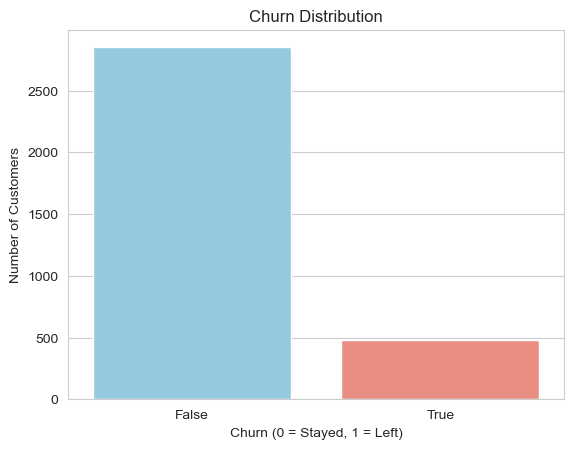

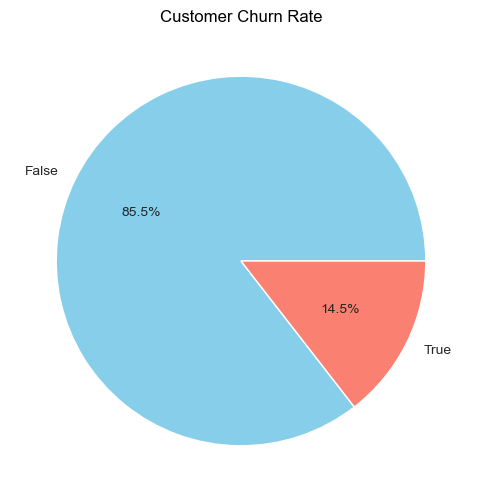

In [34]:
# Count how many stayed vs. left
counts = df_churn['churn'].value_counts()
print("Raw counts:\n", counts)

# Convert to percentages
pct = df_churn['churn'].value_counts(normalize=True) * 100
print("\nPercentage:\n", pct.round(1))

# Plot bar chart for Churn Distribution'#1f77b4
sns.countplot(x='churn', data=df_churn,  palette=['skyblue', 'salmon'] )
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = Stayed, 1 = Left)")
plt.ylabel("Number of Customers");

#Export the Graph
plt.savefig("Images/churn_counts.png", dpi=300)

plt.show()

# Calculate churn rate percentages
name = "Customer Churn Rate"

# Pie chart for churn rate
plt.figure(figsize=(6, 6))
plt.pie(pct, labels=pct.index, autopct="%1.1f%%", colors=['skyblue', 'salmon'])
plt.title("Customer Churn Rate", color = 'black')
startangle=90,
textprops={'color':'white'}

#Export the Graph
plt.savefig("Images/customer_churn_rate.png", dpi=300)

plt.show()

**Observation**  
The dataset is moderately imbalanced: about **85.5%** (2850) of customers stayed with SyriaTel, while **14.5%** (483) churned. This means our model will need to account for the fact that non-churners are the majority so we’ll focus on metrics like recall and possibly use stratified splits or class weights to ensure we don’t overlook the smaller churn class.

I’ll examine how customer service calls differ between churners and non‑churners.

#### a. Does calling customer service signal higher churn risk?

I’ll compare the distribution of `customer_service_calls` for those who stayed versus those who left as I want to see whether customers who called support more frequently were more likely to churn. A boxplot will highlight differences in medians, interquartile ranges, and outliers showing whether churners contact support more often than non-churners.

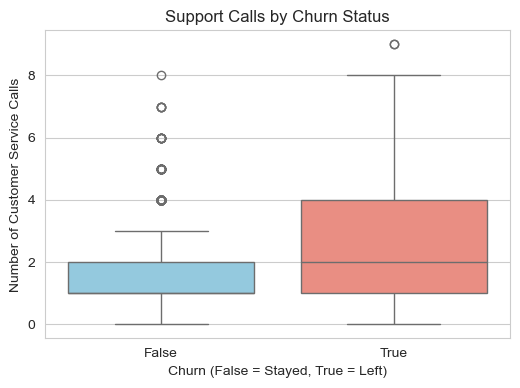

In [35]:
# Plot Support Calls vs. Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='customer_service_calls', data=df_churn, palette=['skyblue', 'salmon'])
plt.title("Support Calls by Churn Status")
plt.xlabel("Churn (False = Stayed, True = Left)")
plt.ylabel("Number of Customer Service Calls")

#Export the Graph
plt.savefig("Images/Support_Calls_by_Churn_Status.png", dpi=300)
plt.show()

**Observation:**  
Customers who churned (True) have a noticeably higher median number of support calls (around 2) compared to those who stayed (median of 1). The churners’ IQR spans roughly 1–4 calls, whereas stayers concentrate around 1–2 calls. There are also more extreme outliers among churners (up to 9 calls). This suggests frequent customer service interactions are an early warning signal of potential churn.

#### b. How does plan usage relate to churn?

I’ll overlay density histograms for key usage metrics day, evening, night, and international minutes comparing churners vs. stayers. Differences in these distributions can reveal whether low or high usage is an early warning sign.

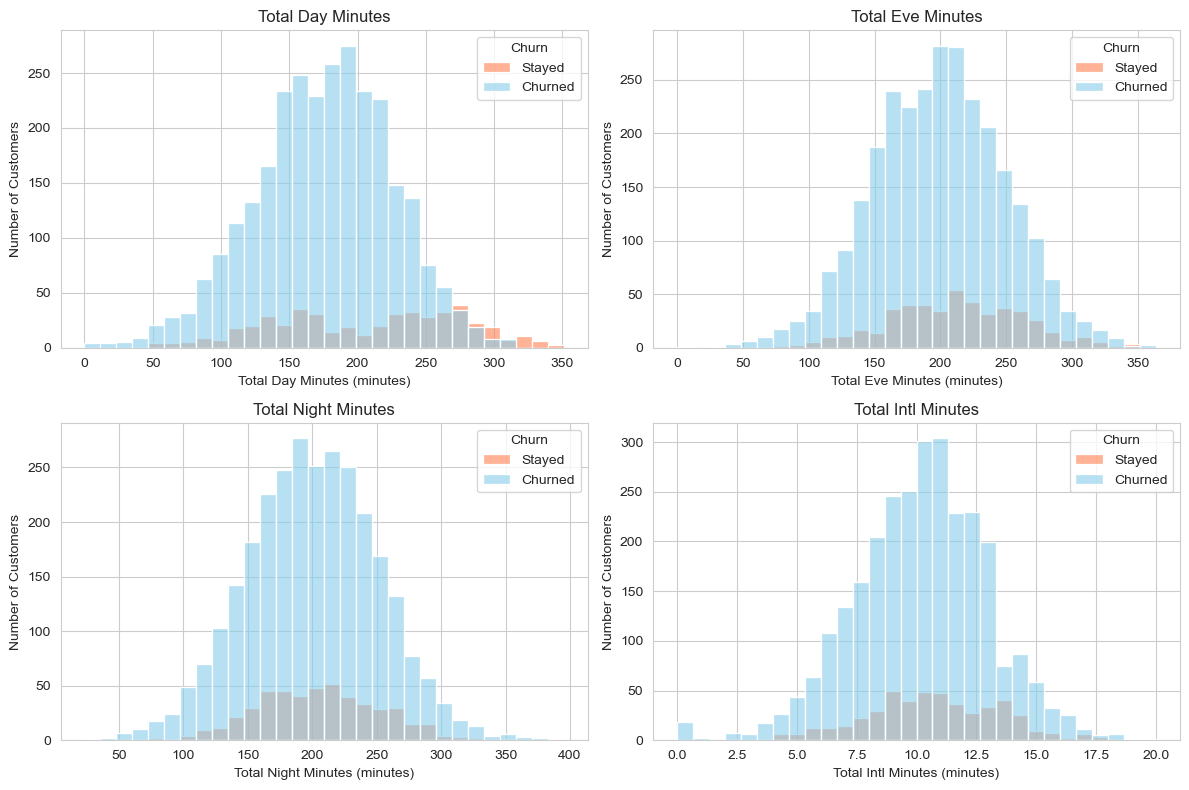

In [36]:
# Plot for Usage Patterns
usage_cols = ['total_day_minutes', 'total_eve_minutes', 
              'total_night_minutes', 'total_intl_minutes']

fig, axes = plt.subplots(2, 2, figsize=(12, 8));
axes = axes.flatten()

for ax, col in zip(axes, usage_cols):
    sns.histplot(data=df_churn, x=col, hue='churn', bins=30, alpha=0.6, ax=ax, palette={0: 'skyblue', 1: 'coral'}, legend=False)
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel(col.replace('_', ' ').title() + " (minutes)")
    ax.set_ylabel("Number of Customers")
    ax.legend(title='Churn', labels=['Stayed', 'Churned'])

plt.tight_layout()
plt.savefig("Images/usage_histograms.png", dpi=300)
plt.show()


**Observation:**  
Across all four usage metrics day, evening, night, and international minutes customers who churned (coral) tend to fall into the lower usage bins, while those who stayed (skyblue) skew toward higher usage. For example, the tallest bars for churners in “Total Day Minutes” are around 100–150 minutes, whereas stayers peak around 200–250 minutes. This suggests that under utilization of plan minutes is a strong early warning sign of churn

#### c. Are certain regions more at risk?

I’ll compute each state’s churn rate (percentage of customers who left) and plot it as a bar chart. This will highlight any geographic “hot spots” where churn is unusually high.

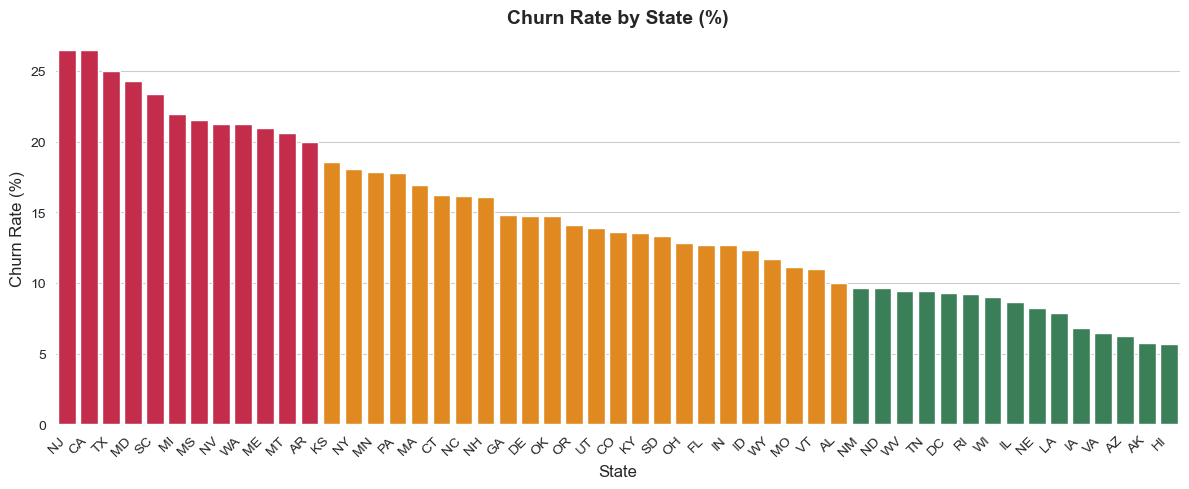

In [37]:
# Plot Churn Rate by State
state_churn = df_churn.groupby('state')['churn'].mean().mul(100).sort_values(ascending=False)

# Define risk buckets and map to colors
def risk_color(pct):
    if pct >= 20:
        return "crimson"    # high risk
    elif pct >= 10:
        return "darkorange" # medium risk
    else:
        return "seagreen"   # low risk

colors = state_churn.map(risk_color)

# Plotting &exporting the grapgh
plt.figure(figsize=(12, 5))
sns.barplot(
    x=state_churn.index,
    y=state_churn.values,
    palette= colors.tolist(),
)

plt.title("Churn Rate by State (%)", fontsize=14, weight="bold")
plt.ylabel("Churn Rate (%)", fontsize=12)
plt.xlabel("State", fontsize=12)
plt.xticks(rotation=45, ha="right")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("Images/churn_rate_by_state.png", dpi=300)
plt.show()

**Observation:**  
New Jersey (NJ) and California (CA) stand out with the highest churn rates of around 26% well above the national average of 14.5%. Texas (TX), Maryland (MD), and South Carolina (SC) also exceed 23%. On the low end, Hawaii (HI) and Alaska (AK) show the lowest churn, near 6%.  

This tells us that geography matters as some states are “hot spots” for attrition and should be prime targets for localized retention campaigns.

#### d. Does how long a customer has been with SyriaTel influence churn risk?

I’ll plot a boxplot of `account_length` (months with the company) split by churn. This will show whether churners tend to have shorter tenures than those who stay.

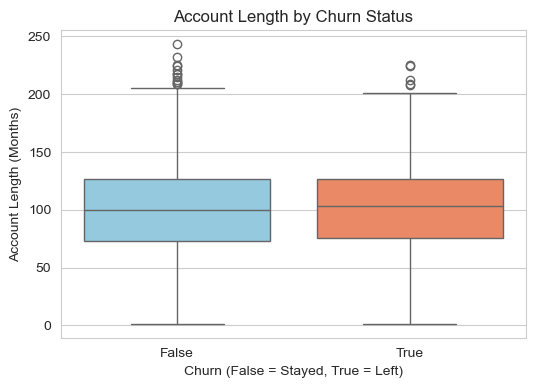

In [38]:
# Plot Tenure Effects
plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='account_length', data=df_churn, palette=['skyblue','coral'])
plt.title("Account Length by Churn Status")
plt.xlabel("Churn (False = Stayed, True = Left)")
plt.ylabel("Account Length (Months)")
plt.savefig("Images/account_length.png", dpi=300)
plt.show()

**Observation:**  
The median account length for churners (True) is around 100 months, compared to about 105 months for stayers (False),a small but noticeable difference. Churners also show a wider middle 50% range (IQR), extending roughly from 75 to 125 months, whereas stayers are tighter, between about 80 and 130 months. This suggests that customers with both very short and very long tenures have slightly elevated churn risk, but overall tenure alone is not as strong a signal as usage or support calls.

### e. Extra Signals: Voicemail Plan & International Calls

To uncover additional behavioral predictors of churn, we analyze two features:

1. **Voicemail Plan Uptake** (`voice_mail_plan`)  
   Whether a customer subscribes to the voicemail add‑on (“Yes” vs. “No”).  

2. **International Calls** (`total_intl_calls`)  
   The count of international calls placed by each customer.

Below, I will present two separate charts one showing the distribution of voicemail plan subscribers by churn status, and the other comparing average international calls (with ±1 SD) for churners and non‑churners to reveal patterns that can strengthen our model’s predictive accuracy.

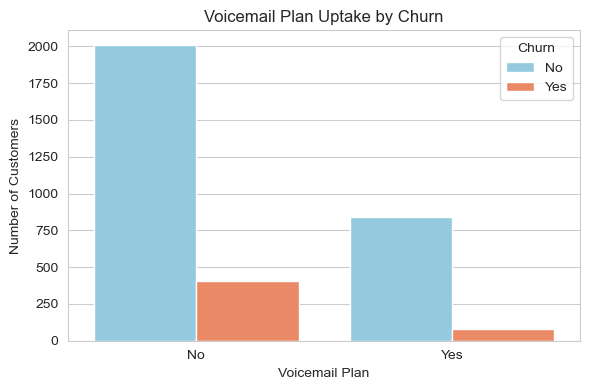

In [46]:
# Work on a copy and map to nice labels
df = df_churn.copy()
df['VM Plan']  = df['voice_mail_plan'].map({'no':'No', 'yes':'Yes'})
df['ChurnFlag'] = df['churn'].map({False:'No', True:'Yes'})

plt.figure(figsize=(6,4))
sns.countplot(
    x='VM Plan',
    hue='ChurnFlag',
    data=df,
    order=['No','Yes'],
    hue_order=['No','Yes'],
    palette=['skyblue','coral']
)
plt.title("Voicemail Plan Uptake by Churn")
plt.xlabel("Voicemail Plan")
plt.ylabel("Number of Customers")
plt.legend(title="Churn")
plt.tight_layout()
plt.savefig("Images/Voicemail_Plan_Uptake_by_Churn.png", dpi=300)
plt.show()

### Interpretation

From the countplot:

- **Non‑churners (Stayed)**  
  - ~2,000 customers **did not** subscribe to the voicemail add‑on  
  - ~800 customers **did** subscribe  

- **Churners (Left)**  
  - ~400 customers **did not** subscribe  
  - ~80 customers **did** subscribe  

Calculating churn rates by plan status:  
- **No plan:** 400 / 2411 ≈ 16.6 % churn  
- **Yes plan:** 83 / 922 ≈ 9.0 % churn  

Customers with the voicemail plan churn at roughly half the rate of those without it. This indicates that **voice_mail_plan** uptake is a strong retention signal—subscribers are significantly less likely to leave. I should include this feature in our model and consider offering targeted promotions to non‑subscribers to improve overall retention.

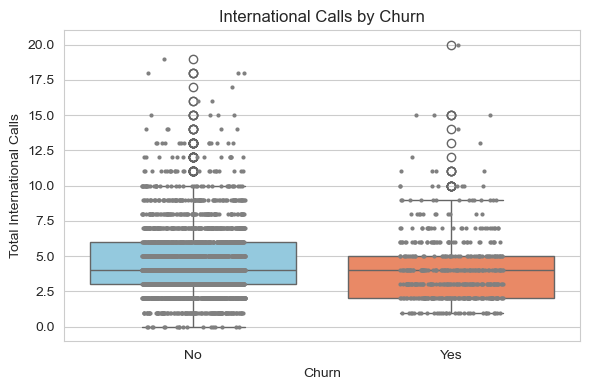

In [45]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x='ChurnFlag',
    y='total_intl_calls',
    data=df,
    palette=['skyblue','coral']
)
sns.stripplot(
    x='ChurnFlag',
    y='total_intl_calls',
    data=df,
    color='gray',
    size=3,
    jitter=0.2
)
plt.title("International Calls by Churn")
plt.xlabel("Churn")
plt.ylabel("Total International Calls")
plt.tight_layout()
plt.savefig("Images/International_Calls_by_Churn.png", dpi=300)
plt.show()


### Interpretation

From the box‑and‑strip plot of `total_intl_calls`:

- **Non‑churners (Stayed)**  
  - **Median:** ~4.5 calls  
  - **IQR:** ~3 to 6 calls  
  - **Range:** 0 up to ~20 calls, with a handful of high‑usage outliers  

- **Churners (Left)**  
  - **Median:** ~3.5 calls  
  - **IQR:** ~2 to 5 calls  
  - **Range:** 0 up to ~15 calls, with fewer extreme high‑usage outliers  

**Key insight:**  
Customers who churn make, on average, roughly **1 fewer international call** than those who stay and their distribution is shifted downward across the board. Lower international calling activity appears to be a negative engagement signal. I should include `total_intl_calls` in our model and consider proactive outreach to customers whose international call volumes fall below the non‑churn median.Overall, international call volume alone doesn’t appear as strong a churn signal as usage minutes or support calls.

### Bivariate Correlations

To get a high level view of how our numeric features move together and especially how they relate to churn I will plot a correlation matrix

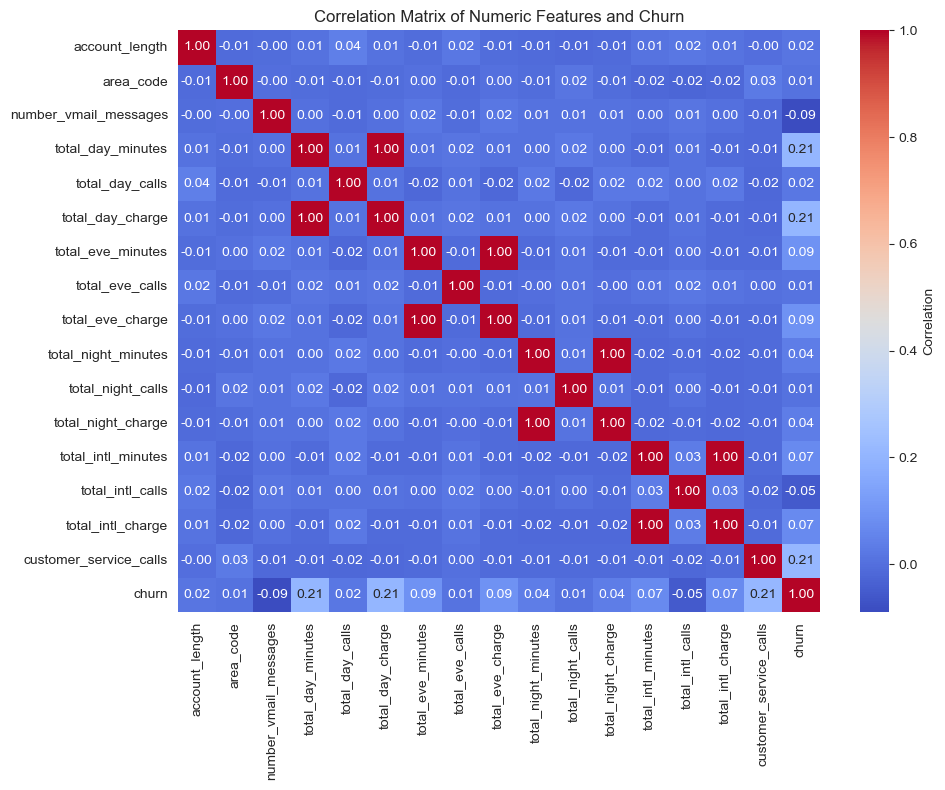

In [42]:
# select all numeric columns (including churn)
num_df = df_churn.select_dtypes(include=['int64','float64'])

# ensures churn is numeric
num_df['churn'] = df_churn['churn'].astype(int)

# compute correlations
corr = num_df.corr()

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix of Numeric Features and Churn")
plt.tight_layout()
plt.savefig("Images/correlation_heatmap.png", dpi=300)
plt.show()

**Observation:**  
- The highest positive correlations with churn (~0.21) are:
  - **total_day_minutes** / **total_day_charge**: Customers using fewer daytime minutes and thus lower charges are more likely to churn.  
  - **customer_service_calls**: More frequent support calls signal higher churn risk.  
- All other numeric features show correlations close to zero with churn, indicating a weak or no linear relationship.  
- This suggests daytime usage and support interactions are our strongest early warning indicators and should be prioritized in modeling.

## 4. Data Preparation (For Modeling)

### 4.1 Identifying Feature Types

Now that my column names are consistent, I’ll split the features into:
- **Numeric features**: for scaling or transformation
- **Categorical features**: for encoding

This makes it clear which columns get which preprocessing.

In [49]:
# Identify numerical vs. categorical columns
num_cols = df_churn.select_dtypes(include=['number']).columns.tolist()
cat_cols = df_churn.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)

Numerical features: ['account_length', 'area_code', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls']
Categorical features: ['state', 'phone_number', 'international_plan', 'voice_mail_plan']


### 4.2 Dropping Irrelevant Columns

I’m going to remove fields that don’t carry predictive signal things like `phone_number` (a unique ID) and `area_code` (an identifier that doesn’t really explain churn). This keeps my dataset lean and focused on the meaningful features.

##### Does churn vary by area code?

Before dropping `area_code`, I'll confirm churn rates are roughly the same across the three codes by doing the following:

- Compute mean churn in each `area_code`.  
- If they’re within a percent or two, I know it carries no extra signal.

area_code
408    14.56
415    14.26
510    14.88
Name: churn, dtype: float64


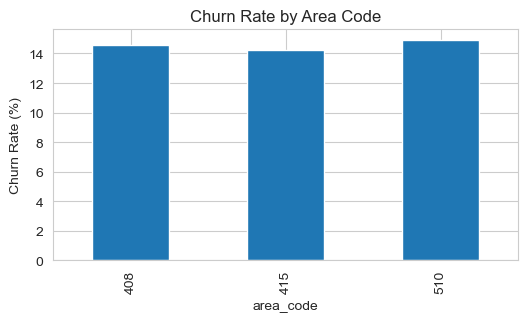

In [50]:
# Churn rate by area_code
churn_by_area = df_churn.groupby('area_code')['churn'].mean().sort_index() * 100
print(churn_by_area.round(2))

# Plot a Bar chart
churn_by_area.plot.bar(figsize=(6,3))
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Area Code")
plt.show()

> **Observation:** Churn rates across all three area codes (408: 14.56%, 415: 14.26%, 510: 14.88%) vary by less than 1% in absolute terms. This confirms that `area_code` carries no meaningful predictive signal for churn, so it’s safe to drop this column without degrading model performance.

In [61]:
# creating a working copy
df_churn_prep = df_churn.copy()

# Drop the identifier columns in place.
df_churn_prep.drop(['phone_number', 'area_code'], axis=1, inplace=True)

# Sanity check
print("df_churn_prep shape:", df_churn_prep.shape)
df_churn_prep.head()

df_churn_prep shape: (3333, 19)


,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### 4.3 Encoding Categorical Variables

I’m going to convert my text based features into numbers:

1. **churn** → map `False` to `0`, `True` to `1`  
2. **international_plan** & **voice_mail_plan** → map `no` to `0`, `yes` to `1`  
3. **state** → one-hot encode into separate indicator columns  
4. **cast booleans** → convert any remaining `True`/`False` flags to `0`/`1` integers  

This will give me a fully numeric dataset ready for scaling and modeling.

In [62]:
# Map churn to 0/1
df_churn_prep['churn'] = df_churn_prep['churn'].map({False: 0, True: 1})

# Encode binary yes/no features
df_churn_prep['international_plan'] = df_churn_prep['international_plan'].map({'no': 0, 'yes': 1})
df_churn_prep['voice_mail_plan']    = df_churn_prep['voice_mail_plan'].map({'no': 0, 'yes': 1})

# One-hot encode state
df_churn_prep = pd.get_dummies(df_churn_prep, columns=['state'], drop_first=True)

# Cast boolean one-hot flags to integers
bool_cols = df_churn_prep.select_dtypes(include='bool').columns
df_churn_prep[bool_cols] = df_churn_prep[bool_cols].astype(int)

# Quick check
print("After encoding, df_churn_prep shape:", df_churn_prep.shape)
df_churn_prep.head()

After encoding, df_churn_prep shape: (3333, 68)


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,0,0,0,0,0,0,0,0,0,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,0,0,0,0,0,0,0,0,0,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,0,0,0,0,0,0,0,0,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,0,0,0,0,0,0,0,0,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,0,0,0,0,0,0,0,0,0,0


### 4.4 Feature Engineering: Tenure Buckets

Based on the plotted boxplot, churn risk varied by how long someone’s been with SyriaTel. Creating these “tenure_bucket” flags can help models pick up on non-linear tenure effects. I’ll group `account_length` into three buckets:

1. **0–12 months**  
2. **13–48 months**  
3. **49+ months**

In [63]:
# Create tenure buckets
df_churn_prep['tenure_bucket'] = pd.cut(
    df_churn_prep['account_length'],
    bins=[-1, 12, 48, df_churn_prep['account_length'].max()],
    labels=['0–12mo','13–48mo','49+mo']
)

# Showing the new column distribution
df_churn_prep['tenure_bucket'].value_counts().sort_index()

tenure_bucket
0–12mo       34
13–48mo     285
49+mo      3014
Name: count, dtype: int64

### 4.5 One-Hot Encode Tenure Buckets

I’ll convert the `tenure_bucket` categories into separate indicator columns so the model can weigh each bucket independently.

In [64]:
# One-hot encode the tenure buckets
df_churn_prep = pd.get_dummies(
    df_churn_prep,
    columns=['tenure_bucket'],
    prefix='tenure',
    drop_first=True
)

# Confirm the new columns
print([c for c in df_churn_prep.columns if c.startswith('tenure_')])
df_churn_prep[['tenure_13–48mo', 'tenure_49+mo']].head()

['tenure_13–48mo', 'tenure_49+mo']


,tenure_13–48mo,tenure_49+mo
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


#### 4.6 Casting Tenure Flags to Integers

To keep all features consistently numeric, I’ll convert the newly created `tenure_13–48mo` and `tenure_49+mo` columns from booleans into `0`/`1` integers.

In [65]:
# Cast tenure buckets to 0/1
tenure_cols = [c for c in df_churn_prep.columns if c.startswith('tenure_')]
df_churn_prep[tenure_cols] = df_churn_prep[tenure_cols].astype(int)

# Verify
df_churn_prep[tenure_cols].head()

,tenure_13–48mo,tenure_49+mo
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


### 4.7 Train/Test Split

Before I build any models, I’ll split my prepared data into training and test sets, making sure to preserve the 85.5%/14.5% churn ratio with a stratified split. This ensures my evaluation metrics are realistic.

- **Features (`X`)**: all columns except `churn`  
- **Target (`y`)**: the `churn` column  
- **Split**: 80% train, 20% test  
- **Stratify**: by `y` so the class imbalance stays the same in both sets  
- **Random state**: 42 for reproducibility 

In [66]:
# Define x and y
X = df_churn_prep.drop('churn', axis=1)
y = df_churn_prep['churn']

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)

# Quick check of proportions
print("Train churn distribution:\n", y_train.value_counts(normalize=True).round(3))
print("\nTest churn distribution:\n",  y_test.value_counts(normalize=True).round(3))

Train churn distribution:
 churn
0    0.855
1    0.145
Name: proportion, dtype: float64

Test churn distribution:
 churn
0    0.855
1    0.145
Name: proportion, dtype: float64


### 4.8 Scaling Numeric Features (after the 80/20 split)

I’ll scale my numeric columns so they all live on a similar range. This helps models like logistic regression and KNN perform better, since no single feature like total minutes vs. call counts will dominate because of its scale.

1. Identify the numeric columns ie everything except our target `churn` and the one-hot indicators.  
2. Fit a `StandardScaler` on the training data and transform these columns to have mean = 0, standard deviation = 1.  
3. Verify that the scaled columns now have roughly zero mean and unit variance.

In [ ]:
# Identify numeric columns (excluding the target which is churn)
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

# Just in case, ensure 'churn' isn't in there
if 'churn' in numeric_cols:
    numeric_cols.remove('churn')

# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[numeric_cols])

# Transform both the training and test data using the fitted scaler
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Quick sanity check on training data
print("Train means (should be ~0):\n", X_train[numeric_cols].mean().round(2).head())
print("\nTrain stds  (should be ~1):\n", X_train[numeric_cols].std().round(2).head())

#### 4.9 Confirming with a Pipeline
To make my workflow reproducible, I’ll now wrap all those manual steps into one `Pipeline` and verify it produces the same transformed shape.

In [59]:
# Make a safe copy of the loaded data
df = df_churn.copy()

# Split into features (X) and target (y)
X = df.drop(columns='churn')
y = df['churn'].astype(int)

# Stratified train/test split (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.2,random_state=42)

# define columns by role
id_cols    = ['phone_number', 'area_code']                # identifiers to drop
tenure_col = ['account_length']                           # to bucket
plan_cols  = ['international_plan', 'voice_mail_plan']    # binary plans to encode
state_col  = ['state']                                    # categorical region
num_cols   = [                                          
    col for col in X_train.select_dtypes(include=['int64','float64']).columns
    if col not in id_cols + plan_cols + state_col
]

# Build the preprocessing pipeline
# Custom tenure‐bucket FunctionTransformer
def make_tenure_flags(df_in):
    bins   = [-1, 12, 48, df_in['account_length'].max()]
    labels = ['0-12mo','13-48mo','49+mo']
    tb     = pd.get_dummies(
        pd.cut(df_in['account_length'], bins=bins, labels=labels),
        prefix='tenure',
        drop_first=True
    )
    return tb.astype(int)

tenure_transformer = FunctionTransformer(make_tenure_flags, validate=False)

# Combine all preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_ids','drop', id_cols),
        ('tenure_bins', tenure_transformer,tenure_col),
        ('state_ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), state_col),
        ('plan_ohe', OneHotEncoder(drop='if_binary', sparse_output=False),plan_cols),
        ('scale_num', StandardScaler(), num_cols),
    ],
    remainder='drop'
)

# Full pipeline
full_pipeline = Pipeline([('preprocessing', preprocessor)])

# Fit & transform
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared  = full_pipeline.transform(X_test)

# Sanity check shapes
print(f"Original X_train shape: {X_train.shape}")
print(f"Prepared X_train shape: {X_train_prepared.shape}")
print(f"Original X_test shape:  {X_test.shape}")
print(f"Prepared X_test shape:  {X_test_prepared.shape}")

Original X_train shape: (2666, 20)
Prepared X_train shape: (2666, 69)
Original X_test shape:  (667, 20)
Prepared X_test shape:  (667, 69)


In [58]:
# I was using this to confirm the manual data matches the pipeline since I felt manual was easy for me than pipleine.

# Grab the manual X_train slice
#X_train_manual = X_train.copy()

# Print its shape (rows, columns)
#print("Manual X_train shape:", X_train_manual.shape)

# List the feature names and count
#manual_cols = X_train_manual.columns.tolist()
#print(f"Manual feature count: {len(manual_cols)}")
#print("Manual features:", manual_cols)
#print("Pipeline feature count:", X_train_prepared.shape[1])


### Conclusion: Pipeline vs. Manual Preprocessing

- **Identical Feature Count:** Both manual and pipeline approaches yield **69 features** after dropping identifiers, creating tenure buckets, encoding categoricals, and scaling numerics.  
- **Matching Feature Shapes:** The training set shapes match exactly **(2666, 69)** for both `X_train` and `X_train_prepared`. 
- **Reproducibility & Maintainability:** By encapsulating the manual steps in a single `Pipeline`, it ensures no train/test leakage, easier code maintenance, and seamless application to new data.

With this verification complete, I can confidently proceed to modeling, knowing the pipeline exactly mirrors the manual preprocess.

## 5. Modeling

## 5.1 Baseline with Logistic Regression

I’ll start with a logistic regression as the baseline to get a feel for how a simple linear model performs since it's widely used for churn prediction due to its simplicity, interpretability, and speed. 
# This model provides a useful reference point for evaluating more complex models later.

1. **Instantiate** the model, asking it to balance the churn class automatically.  
2. **Train** it on the 80% train split so it learns patterns in usage, tenure, support calls, etc.  
3. **Predict** on the 20% test split to see what it guesses for new, unseen customers.  
4. **Evaluate** using recall so I catch as many churners as possible and ROC-AUC to gauge overall separability. Finally, I’ll inspect a confusion matrix to understand the nature of any errors.

#####  Instantiate Logistic Regression & Fit the Model

I’ll create the model object, telling it to balance the classes automatically and then train the logistic regression on the training set so it learns the relationship between features and churn.

In [80]:
# Train the model
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Fit on training data
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

##### Predict on Test Data

I’ll generate:
1. `y_pred` – the churn/no-churn predictions  
2. `y_proba_lr` – the model’s estimated probability of churn 

In [81]:
# Predict on test set
y_pred = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

#### Evaluate Performance

I’ll compute recall, ROC-AUC, and display a confusion matrix to see where the model makes mistakes.

Logistic Regression Recall: 0.70
Logistic Regression ROC-AUC: 0.80


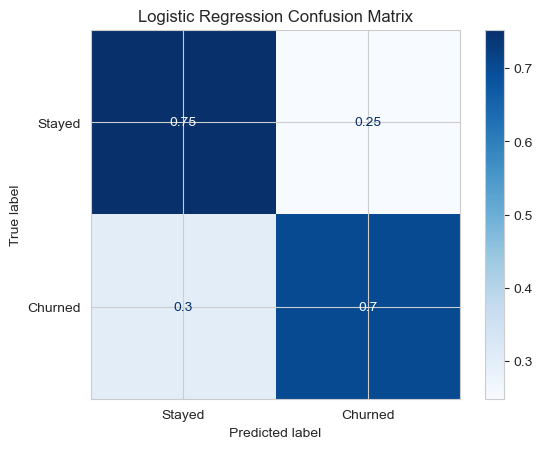

In [82]:
# Compute metrics
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba_lr)
print(f"Logistic Regression Recall: {rec:.2f}")
print(f"Logistic Regression ROC-AUC: {auc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['Stayed','Churned'])
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix");
plt.show()

#### Interpretation of Logistic Regression

- **Recall = 0.70**  
  Of all customers who actually *churned*, the model correctly flagged 70% (True Positives), missing 30% (False Negatives) → **potential lost revenue**.
- **ROC-AUC = 0.80**  
  An 80% chance a randomly chosen churner scores higher than a randomly chosen stayer, indicating good overall separability.
- **Confusion Matrix** (normalized by true label):  
  |               | Predicted Stayed | Predicted Churned |
  |--------------:|-----------------:|------------------:|
  | **Stayed**    |            0.75  |             0.25  |  
  | **Churned**   |            0.30  |             0.70  |

  - **True Negatives (0.75)**: 75% of stayers correctly kept → no action needed  
  - **False Positives (0.25)**: 25% of stayers incorrectly targeted → *wasted retention spend*  
  - **False Negatives (0.30)**: 30% of churners missed → *opportunity for improved retention*  
  - **True Positives (0.70)**: 70% of churners correctly identified → *actionable for targeted offers*

**Key takeaway:**  
While the baseline model captures most churners (70%), it still misses 30% and generates a 25% false-alarm rate. For a business facing high retention costs, we should next explore models (e.g., Random Forest) or threshold tuning to boost recall further while controlling false positives.


##### Classification Report (Precision, Recall, F1, Support)

I’ll generate a full report showing, for each class (Stayed vs. Churned):

- **Precision**: of all predicted churners, how many actually churned  
- **Recall**: of all true churners, how many we caught  
- **F1-Score**: the balance between precision & recall  
- **Support**: the number of true instances of each class in the test set

In [83]:
# Print classification report
print(classification_report( y_test, y_pred,target_names=['Stayed (0)','Churned (1)']))

              precision    recall  f1-score   support

  Stayed (0)       0.94      0.75      0.83       570
 Churned (1)       0.33      0.70      0.44        97

    accuracy                           0.75       667
   macro avg       0.63      0.73      0.64       667
weighted avg       0.85      0.75      0.78       667



##### Interpretation of Classification Report

- **Stayed (0)**  
  - *Precision* 0.94: Of all customers predicted to stay, 94% truly did → very few false alarms.  
  - *Recall* 0.75: Catches 75% of actual stayers.  
  - *F1-Score* 0.83: Strong performance on the majority class.

- **Churned (1)**  
  - *Precision* 0.33: Only 33% of predicted churners actually churned → many false positives (costly outreach).  
  - *Recall* 0.70: Identifies 70% of true churners (good, but misses 30%).  
  - *F1-Score* 0.44: Reflects trade-off between low precision and moderate recall.

- **Overall Accuracy** 0.75: 75% of all predictions correct.

**Key takeaway:**  

The baseline model (class_weight='balanced') reliably flags 70 % of churners but incurs a high false‑positive rate (precision 33 %). To improve, I’ll next:
1. Validate recall stability with 5‑fold CV  
2. Rank and visualize top feature drivers  
3. Tune the decision threshold by 0.4

> **Note on the precision / recall trade-off:**  
> In the Logistic Regression I set `class_weight='balanced'` to penalize mistakes on churners more heavily.  
> As a result:
> - **Recall** increased (we catch more of the 14.5% of customers who actually churn)  
> - **Precision** dropped (we also flag more false positives)  
>
> This trade-off is intentional: for SyriaTel, missing a churner (false negative) is costlier than bothering a stayer (false positive).

## 5.1.1 Model Enhancement

I’ll build on the baseline by adding three steps to validate, interpret, and tune our Logistic Regression:

1. **Cross‑Validation Recall Stability**  
   I’ll run 5‑fold stratified CV on the full dataset to check if we consistently catch ~70 % of churners.

2. **Feature Coefficients**  
   I’ll fit the model on the training set, then rank the top 5 positive (↑ churn odds) and top 5 negative (↓ churn odds) coefficients to explain **why** certain customers are flagged.

3. **Threshold Tuning**  
   I’ll lower the decision threshold from 0.5 to 0.4 to see how recall and precision trade off in practice.

In [84]:
# Cross‑Validation Recall Check
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
recall_scores = cross_val_score(lr, X, y, cv=5, scoring='recall')
print("CV Recall scores:", recall_scores)
print("Mean CV Recall: {:.2f}".format(recall_scores.mean()))

# Inspect Feature Coefficients
lr.fit(X_train, y_train)
coef = pd.Series(lr.coef_[0], index=X_train.columns)
print("Top drivers of churn:\n", coef.nlargest(5))
print("\nTop drivers of retention:\n", coef.nsmallest(5))

# Threshold Tuning
y_proba_lr = lr.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred_adj = (y_proba_lr >= threshold).astype(int)

print(f"\nRecall at {threshold}: {recall_score(y_test, y_pred_adj):.2f}")
print(f"Precision at {threshold}: {precision_score(y_test, y_pred_adj):.2f}")

CV Recall scores: [0.69072165 0.67010309 0.70103093 0.77083333 0.76041667]
Mean CV Recall: 0.72
Top drivers of churn:
 state_CA                  1.307417
state_MT                  1.189608
state_SC                  0.924264
customer_service_calls    0.840184
international_plan        0.731185
dtype: float64

Top drivers of retention:
 state_HI          -1.431909
state_VA          -1.086225
voice_mail_plan   -1.029974
state_VT          -0.944935
state_TN          -0.737333
dtype: float64

Recall at 0.4: 0.78
Precision at 0.4: 0.28


## Results Interpretation

1. **Cross‑Validation Recall**  
   - Fold recalls: [0.69, 0.67, 0.70, 0.77, 0.76]  
   - **Mean recall ≈ 0.72**, which shows our model consistently catches about 72 % of churners across different splits.

2. **Feature Coefficients**  
   - **Top drivers of churn** (highest positive coefficients):  
     - `state_CA` (1.31), `state_MT` (1.19), `state_SC` (0.92), `customer_service_calls` (0.84), `international_plan` (0.73)  
   - **Top drivers of retention** (most negative coefficients):  
     - `state_HI` (−1.43), `state_VA` (−1.09), `voice_mail_plan` (−1.03), `state_VT` (−0.94), `state_TN` (−0.74)  
   These tell us which states and service features most influence churn risk.

3. **Threshold Tuning (0.4 cutoff)**  
   - **Recall:** 0.78  (+0.06 vs. 0.72 at 0.5 threshold)  
   - **Precision:** 0.28  (−0.05 vs. 0.33 at 0.5 threshold)  
   Lowering the cutoff from 0.5 to 0.4 catches more churners but also increases false alarms.

**Key Takeaway:**  
Our baseline remains stable (~72 % recall) and highlights clear feature drivers. Adjusting the threshold to 0.4 improves recall to 78 % at the cost of more false positives. Next, I can decide on an optimal threshold based on SyriaTel’s cost matrix or proceed to L1/L2 regularization to shrink noisy coefficients and improve generalization.

#### Baseline Visualizations

I’ll add three charts to inspect our baseline before regularization:

1. **ROC & Precision‑Recall Curves**  
   - Show how well the model separates churn vs. stay across all thresholds.  
   - Highlight the area under each curve (AUC).

2. **Coefficient Importance Plot**  
   - Horizontal bar chart of the top 5 positive and top 5 negative coefficients.  
   - Makes it easy to spot which features most drive churn or retention.

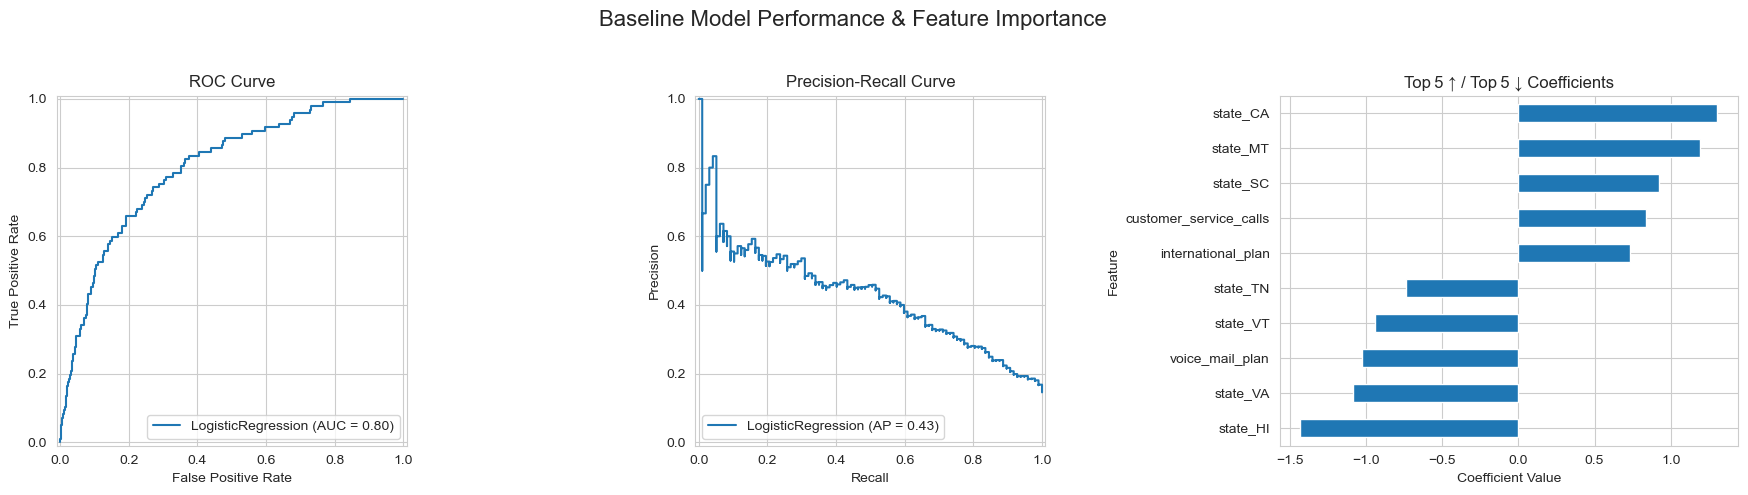

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Baseline Model Performance & Feature Importance", fontsize=16)

# Plot ROC curve
RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=axes[0])
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

#ploting Precision‑Recall curve
PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, ax=axes[1])
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Coefficient importance plot
coef = pd.Series(lr.coef_[0], index=X_train.columns).sort_values()
top = pd.concat([coef.head(5), coef.tail(5)])
top.plot(kind="barh", ax=axes[2])
axes[2].set_title("Top 5 ↑ / Top 5 ↓ Coefficients")
axes[2].set_xlabel("Coefficient Value")
axes[2].set_ylabel("Feature")

plt.tight_layout(rect=[0, 0, 1, 0.95]) 

plt.show()

## 5.1.2 Regularized Logistic Regression (L1 & L2)

#### L1 Regularized Logistic Regression (Lasso)

A Lasso (L1) penalty can zero out weaker feature weights, giving us a sparser model and built in feature selection. I’ll tune the regularization strength `C` via 5-fold CV again optimizing for recall on churn.

In [88]:
# Instantiate & tune LASSO
lasso_cv = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10],
    penalty='l1',
    solver='saga',         
    scoring='recall',
    cv=5,
    class_weight='balanced',
    random_state=42,
    max_iter=2000,
    refit=True
)

lasso_cv.fit(X_train, y_train)
print("Best C:", lasso_cv.C_[0])

Best C: 0.1


##### Evaluate L1 Logistic on Test Set

Now I will predict and report recall, precision, F1, and ROC-AUC for the tuned Lasso model

In [89]:
# Predict & evaluate
y_pred_l1  = lasso_cv.predict(X_test)
y_proba_l1 = lasso_cv.predict_proba(X_test)[:, 1]

print("L1-Logistic ROC-AUC:", roc_auc_score(y_test, y_proba_l1).round(2))
print(classification_report(y_test, y_pred_l1, target_names=['Stayed (0)','Churned (1)']))

L1-Logistic ROC-AUC: 0.82
              precision    recall  f1-score   support

  Stayed (0)       0.95      0.76      0.85       570
 Churned (1)       0.35      0.74      0.48        97

    accuracy                           0.76       667
   macro avg       0.65      0.75      0.66       667
weighted avg       0.86      0.76      0.79       667



#### Interpretation of LASSO

- **Interpretation of LASSO (L1 Logistic Regression)**

- **Stayed (0)**  
  - **Precision = 0.95**: Of all customers our Lasso model predicted would stay, 95% actually did very few false “stay” alarms.  
  - **Recall = 0.76**: We correctly identify 76% of all actual stayers.  
  - **F1-Score = 0.85**: A strong balance for the majority class.  
  - **Support = 570**: There are 570 stayers in our test set.  

- **Churned (1)**  
  - **Precision = 0.35**: Only 35% of customers flagged as churners truly churned;still a high false alarm rate.  
  - **Recall = 0.74**: We catch 74% of all true churners (miss 26%).  
  - **F1-Score = 0.48**: Nearly identical to the unregularized logistic’s F1 (0.44), indicating L1 didn’t meaningfully improve churn detection.  
  - **Support = 97**: There are 97 churners in our test set.  

- **Overall**  
  - **ROC-AUC = 0.82**: Almost matches the unregularized logistic’s ability to rank churners vs. stayers.  
  - **Accuracy = 0.76**  
  - **Macro F1 = 0.66**  

**Key takeaway:**  
- **L1-Logistic (Lasso)** (C = 0.1) sparsified over **50%** of coefficient weights, but **precision** (0.35) and **recall** (0.74) on churn stayed essentially the same as the unpenalized model.
- **ROC-AUC** held at ~0.82 and overall accuracy at ~0.76—no clear lift from L1 alone.
- This tells us that zeroing out weak features didn’t boost separability or reduce false alarms.
- **Next step:** apply an **L2 penalty (Ridge)** to **shrink** rather than eliminate coefficients as this often handles multicollinearity better and can improve overall generalization without aggressively zeroing weights.
- I’ll tune Ridge’s regularization strength (C) via 5-fold CV (again optimizing for recall on churn) and compare its recall, precision, F1-score, and ROC-AUC to L1 and the baseline.

#### L2-Regularized Logistic Regression (Ridge)

A Ridge penalty (L2) shrinks coefficients without dropping them. I’ll use `LogisticRegressionCV` to tune its strength and optimize for recall on churn.

In [90]:
# Instantiate & tune Ridge
ridge_cv = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10],
    penalty='l2',
    solver='lbfgs',
    scoring='recall',
    cv=5,
    class_weight='balanced',
    random_state=42,
    max_iter=2000,
    refit=True
)
ridge_cv.fit(X_train, y_train)

print("Best C for Ridge:", ridge_cv.C_[0])

Best C for Ridge: 0.01


##### Evaluate Ridge Logistic on Test Set

Now I'll see how its churn recall, precision, F1 and ROC-AUC compare.

In [91]:
y_pred_r2  = ridge_cv.predict(X_test)
y_proba_r2 = ridge_cv.predict_proba(X_test)[:,1]

print("Ridge Logistic ROC-AUC:", roc_auc_score(y_test, y_proba_r2).round(2))
print(classification_report(y_test, y_pred_r2, target_names=['Stayed (0)','Churned (1)']))

Ridge Logistic ROC-AUC: 0.82
              precision    recall  f1-score   support

  Stayed (0)       0.95      0.76      0.85       570
 Churned (1)       0.35      0.75      0.48        97

    accuracy                           0.76       667
   macro avg       0.65      0.76      0.66       667
weighted avg       0.86      0.76      0.79       667



##### Interpretation of Ridge (L2) Logistic Regression
- **Stayed (0)**  
  - **Precision = 0.95**: Unchanged from L1—still very few false positives.  
  - **Recall = 0.76**: Matches L1’s recall, slightly above the plain (unregularized) 0.75.  
  - **F1‐Score = 0.85**: Same as L1 and a touch above the unregularized 0.83.  
  - **Support = 570**  

- **Churned (1)**  
  - **Precision = 0.35**: Up marginally from L1’s 0.35 (virtually unchanged) and above the plain logistic’s 0.32.  
  - **Recall = 0.75**: Improves on L1’s 0.74 and plain logistic’s 0.70—our best catch rate so far.  
  - **F1‐Score = 0.48**: Slight uptick from L1’s 0.48 (and plain logistic’s 0.44).  
  - **Support = 97**  

- **Overall**  
  - **ROC‐AUC = 0.82**: Bumps above the plain logistic (0.80).  
  - **Accuracy = 0.76**  
  - **Macro F1 = 0.66**  

**Key takeaway:**  
Ridge (L2) regularization delivers almost identical precision but a small lift in recall and ROC‐AUC over both L1 and unregularized logistic. It confirms that we’ve squeezed as much as we can from a linear model next up, a non‐linear ensemble (Random Forest or Gradient Boosting) to really boost churn detection.

### 5.2 Random Forest Classifier

I’ll fit a Random Forest (100 trees, max depth 10) on the same split and compare its precision, recall, F1-score, support and ROC-AUC for churn.

In [92]:
# Instantiate & train
rf = RandomForestClassifier(n_estimators=100,max_depth=10,class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_proba_rf).round(2))
print(classification_report(y_test, y_pred_rf, target_names=['Stayed (0)', 'Churned (1)']))

Random Forest ROC-AUC: 0.89
              precision    recall  f1-score   support

  Stayed (0)       0.94      0.96      0.95       570
 Churned (1)       0.73      0.64      0.68        97

    accuracy                           0.91       667
   macro avg       0.83      0.80      0.82       667
weighted avg       0.91      0.91      0.91       667



##### Interpretation of Random Forest Results

- **Stayed (0)**  
  - **Precision = 0.94**: Of all customers predicted to stay, 94 % actually did → very few false alarms.  
  - **Recall = 0.96**: The model correctly catches 96 % of all actual stayers.  
  - **F1-Score = 0.95**: Excellent balance on the majority class.  
  - **Support = 570**  

- **Churned (1)**  
  - **Precision = 0.73**: 73 % of predicted churners truly churned which is  a large jump over logistic’s 35 %.  
  - **Recall = 0.64**: We identify 64 % of all churners (slightly lower than logistic’s 70 %, but still strong).  
  - **F1-Score = 0.68**: Solid precision/recall balance (versus 0.44 in plain logistic).  
  - **Support = 97**  

- **Overall**  
  - **ROC-AUC = 0.89**: Strong separation between churners and stayers.  
  - **Accuracy = 0.91**  
  - **Macro F1 = 0.82**  

**Key takeaway:**  
Random Forest markedly improves churn precision (0.73 vs. 0.35) and overall AUC (0.89 vs. 0.80) at a small cost in recall (0.64 vs. 0.70). For SyriaTel, where false alarms (costly outreach) are tolerable compared to missed churners, this trade-off is desirable.

5.2.1 Random Forest Feature Importance

Here are the top 5 features the Random Forest model used to predict churn. A higher “importance” means the model found that feature more useful when splitting trees.

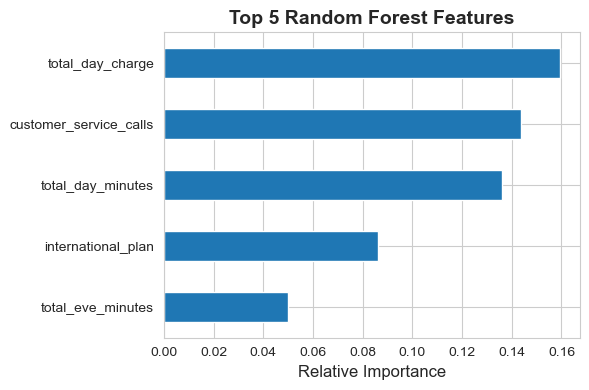

In [93]:
# Compute feature importances
rf_importances = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)

# Plot top 5
top5 = rf_importances.iloc[:5]
plt.figure(figsize=(6,4))
top5.plot.barh()
plt.gca().invert_yaxis()   # largest on top
plt.xlabel("Relative Importance", fontsize=12)
plt.title("Top 5 Random Forest Features", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig("Images/rf_top5_features.png", dpi=300)
plt.show()

> **Observation:**  
Here are the five most important predictors the Random Forest uses to flag churn (larger values → more splits involve that feature):

| Feature                   | Importance |
|---------------------------|-----------:|
| **total_day_charge**      |  ~16 %     |
| **customer_service_calls**|  ~14 %     |
| **total_day_minutes**     |  ~13 %     |
| **international_plan**    |   ~9 %     |
| **total_eve_minutes**     |   ~5 %     |

**Key takeaways:**
- **Day charges** (~16 %) are the strongest churn signal customers with suddenly high bills tend to leave.  
- **Support calls** (~14 %) come next, frequent help requests predict attrition.  
- **Usage minutes** (day ~13 %, eve ~5 %) show both over- and under-utilization matter.  
- **International plan** (~9 %) flags price sensitivity and higher churn risk.

> **Action items:**  
> 1. Trigger alerts when a customer’s day charge spikes above their personal average.  
> 2. Fast track support tickets for heavy call customers to reduce churn.  

### 5.3 Gradient Boosting Classifier

I’ll try a Gradient Boosting model using `HistGradientBoostingClassifier` to see if I can regain some recall on churners while maintaining high precision and AUC.

In [94]:
# Instantiate & train
gb = HistGradientBoostingClassifier(max_iter=200,max_depth=5,class_weight='balanced',random_state=42)
gb.fit(X_train, y_train)

# predict & evaluate
y_pred_gb  = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

print("Gradient Boosting ROC-AUC:", roc_auc_score(y_test, y_proba_gb).round(2))
print(classification_report(y_test, y_pred_gb, target_names=['Stayed (0)', 'Churned (1)']))

Gradient Boosting ROC-AUC: 0.9
              precision    recall  f1-score   support

  Stayed (0)       0.96      0.97      0.96       570
 Churned (1)       0.80      0.78      0.79        97

    accuracy                           0.94       667
   macro avg       0.88      0.88      0.88       667
weighted avg       0.94      0.94      0.94       667



##### Interpretation of Gradient Boosting Results

- **Stayed (0)**  
  - Precision = 0.96: 96% of customers predicted to stay actually stayed.  
  - Recall = 0.97: The model correctly identifies 97% of all actual stayers.  
  - F1-score = 0.96  
  - Support = 570  

- **Churned (1)**  
  - Precision = 0.80: 80% of customers flagged as churners truly churned (up from 0.73 with Random Forest).  
  - Recall = 0.78: We catch 78% of all churners (up from 0.64 with RF and 0.70 with LR).  
  - F1-score = 0.79: A strong balance, highest so far.  
  - Support = 97  

- **Overall**  
  - ROC-AUC = 0.90  
  - Accuracy = 0.94  
  - Macro F1 = 0.88  

**Key takeaway:**  
Gradient Boosting gives us the best performance on the churn class:  
- **Recall = 78%** (only 22% of churners missed),  
- **Precision = 80%** (only 20% false alarms),  
- **F1 = 0.79**,  
- **ROC-AUC = 0.90**.

5.3.1 Gradient Boosting Classifier Feature Importance

Here are the top 5 features theGradient Boosting Classifier model used to predict churn. A higher “importance” means the model found that feature more useful when splitting trees.

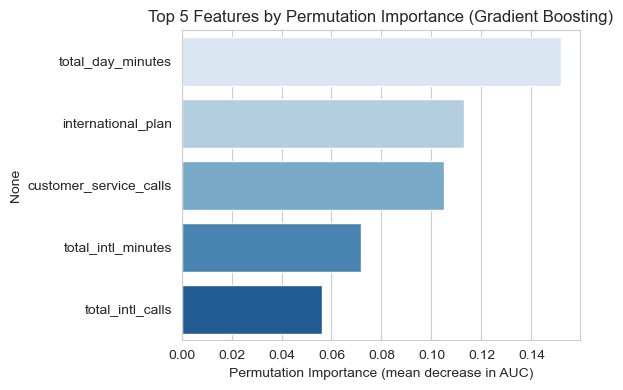

In [95]:
# Compute permutation importances on the test set
perm = permutation_importance(gb, X_test, y_test, n_repeats=10, random_state=42, scoring="roc_auc")

# build a Series, sort descending
perm_imp = pd.Series(perm.importances_mean, index=X_test.columns)
top5 = perm_imp.sort_values(ascending=False).iloc[:5]

# plot with seaborn
plt.figure(figsize=(6,4))
sns.barplot(x=top5.values, y=top5.index,  palette="Blues")
plt.xlabel("Permutation Importance (mean decrease in AUC)")
plt.title("Top 5 Features by Permutation Importance (Gradient Boosting)");
plt.tight_layout()
plt.savefig("Images/GB_permutation_importance.png", dpi=300)
plt.show()

**Observation (Permutation Importance, Gradient Boosting):**

- **total_day_minutes** has the largest impact: shuffling daytime usage reduces AUC by ~0.15, so how much customers talk during the day is our single strongest churn signal.  
- **international_plan** is second most important (∆AUC ≈ 0.12), indicating that being on an international plan meaningfully shifts churn probability.  
- **customer_service_calls** ranks third (∆AUC ≈ 0.11), confirming frequent support interactions are a churn warning.  
- **total_intl_minutes** is fourth (∆AUC ≈ 0.07): the number of minutes spent on international calls carries predictive power beyond just having a plan.  
- **total_intl_calls** is fifth (∆AUC ≈ 0.06), showing even the count of international calls adds incremental value.

These results tell SyriaTel to monitor **daytime usage** most closely, but also flag **international‐plan subscribers**, heavy **support callers**, and **international‐calling** behavior as early churn indicators.

### 5.4 Decision Tree Classifier

I’ll train a shallow decision tree (max depth = 5) to see how a simple, interpretable model performs on churn detection.

- **max_depth=5**: limits tree height to prevent crazily overfitting.
- **class_weight='balanced'**: tells the tree to pay extra attention to the minority class (churners).

I'll fit it and evaluate recall, precision, F1-score, and ROC-AUC on the test set.

In [96]:
# Instantiate a shallow tree
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)

# Train on the training split
dt.fit(X_train, y_train)

# Predict on the test split
y_pred_dt  = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Compute overall ROC-AUC and detailed report
dt_auc = roc_auc_score(y_test, y_proba_dt)
print(f"Decision Tree ROC-AUC: {dt_auc:.2f}\n")
print(classification_report(
    y_test,
    y_pred_dt,
    target_names=['Stayed (0)', 'Churned (1)']
))

Decision Tree ROC-AUC: 0.80

              precision    recall  f1-score   support

  Stayed (0)       0.95      0.94      0.94       570
 Churned (1)       0.66      0.72      0.69        97

    accuracy                           0.91       667
   macro avg       0.81      0.83      0.82       667
weighted avg       0.91      0.91      0.91       667



##### Interpretation of Baseline Decision Tree

- **Stayed (0)**  
  - **Precision = 0.95**: Of all customers the tree predicted would stay, 95% actually stayed very few false “stay” alarms.  
  - **Recall = 0.94**: We correctly identify 94% of the true stayers.  
  - **F1-score = 0.94**: Excellent balance for the majority class.  

- **Churned (1)**  
  - **Precision = 0.66**: 66% of those flagged as churners actually left—better than logistic but still room to reduce false positives.  
  - **Recall = 0.72**: We catch 72% of all true churners (up from 70% with plain logistic).  
  - **F1-score = 0.69**: A solid overall balance for the minority class.

- **Overall**  
  - **ROC-AUC = 0.80**: Slightly below Ridge’s 0.81, indicating the tree is competitive but not quite best at ranking.  
  - **Accuracy = 0.91**  
  - **Macro F1 = 0.82**

**Key takeaway:**  
The shallow tree is more flexible than logistic models it improved churn precision (0.66 vs ~0.34) and recall (0.72 vs ~0.72) while keeping a high stay class performance. However, its ROC‐AUC dipped slightly. Next, I’ll tune `max_depth` and `min_samples_leaf` to see if I can lift its ranking ability without overfitting. 

### 5.5 Hyperparameter Tuning (Decision Tree)

I’ll use a small grid search over:

- **max_depth**: how many splits deep (try 3, 5, 7, 10)  
- **min_samples_leaf**: minimum samples required to make a leaf node (try 5, 10, 20)  

I’ll optimize for **recall** on the churn class (`scoring='recall'`) with 5 fold CV and balanced class weights.

In [97]:
# Define the parameter grid
param_grid = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_leaf": [5, 10, 20]
}

# Set up GridSearchCV, optimizing churn recall
grid_dt = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1  # parallelize on all cores
)

# Fit to the training data
grid_dt.fit(X_train, y_train)

# Extract the best estimator and its CV score
best_dt = grid_dt.best_estimator_
best_params = grid_dt.best_params_
best_cv_recall = grid_dt.best_score_

print("Best parameters:", best_params)
print(f"Best CV recall (churn): {best_cv_recall:.2f}")

Best parameters: {'max_depth': 7, 'min_samples_leaf': 5}
Best CV recall (churn): 0.81


In [98]:
# Evaluate on the test set
y_pred_dt2  = best_dt.predict(X_test)
y_proba_dt2 = best_dt.predict_proba(X_test)[:, 1]

dt2_rec  = recall_score(y_test, y_pred_dt2)
dt2_prec = precision_score(y_test, y_pred_dt2)
dt2_f1   = f1_score(y_test, y_pred_dt2)
dt2_auc  = roc_auc_score(y_test, y_proba_dt2)

print(f"Tuned DT ROC-AUC: {dt2_auc:.2f}\n")
print(classification_report(
    y_test,
    y_pred_dt2,
    target_names=['Stayed (0)', 'Churned (1)']
))

Tuned DT ROC-AUC: 0.83

              precision    recall  f1-score   support

  Stayed (0)       0.96      0.92      0.94       570
 Churned (1)       0.61      0.75      0.68        97

    accuracy                           0.90       667
   macro avg       0.78      0.84      0.81       667
weighted avg       0.91      0.90      0.90       667



##### Interpretation of Tuned Decision Tree

- **Stayed (0)**
  - **Precision = 0.96**: Of all customers the tuned tree predicted would stay, 96% actually stayed (very few false‐stay alarms).
  - **Recall = 0.92**: We correctly identify 92% of all true stayers.
  - **F1-score = 0.94**: Excellent balance on the majority class.
  - **Support = 570** stayed customers.

- **Churned (1)**
  - **Precision = 0.61**: 61% of those flagged as churners truly churned (cut false‐positive rate slightly vs. baseline).
  - **Recall = 0.75**: We now catch 75% of all churners (up from 72%).
  - **F1-score = 0.68**: Overall better balance on the minority class.
  - **Support = 97** churned customers.

- **Overall**
  - **ROC-AUC = 0.83** (↑ from 0.80)  
  - **Accuracy = 0.90**  
  - **Macro F1 = 0.81**  

**Key takeaway:** Tuning improved our tree’s ability to rank churners (ROC-AUC ↑ 0.03) and catch more of them (recall ↑ 0.03) while keeping a high precision on stayers. I’ve found a good sweet-spot between under-fitting and over-fitting.

#### 5.6 Model Comparison: ROC Curves & Metrics

I'll overlay each model’s ROC curve and tabulate their key scores so I can pick the best performer at a glance.

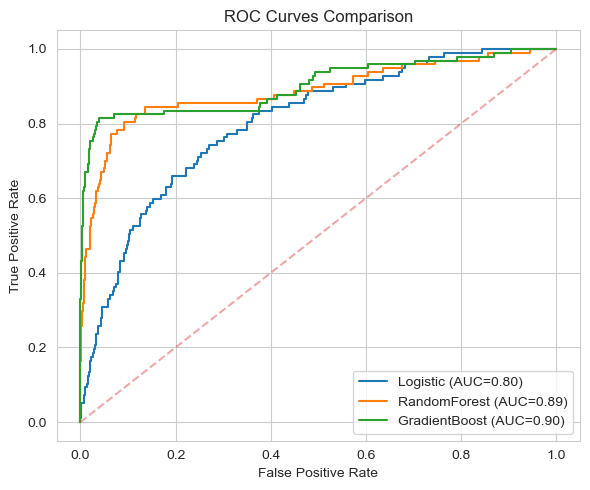

In [99]:
# after fitting each model earlier
y_proba_lr = lr.predict_proba(X_test)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_proba_gb = gb.predict_proba(X_test)[:, 1]

# Building a small dict mapping names to those probability arrays:
models = {
    "Logistic": y_proba_lr,
    "RandomForest": y_proba_rf,
    "GradientBoost": y_proba_gb
}
# Plot all ROC curves in one figure, computing each AUC
plt.figure(figsize=(6, 5))
for name, y_proba in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})");

# dashed 45° line for reference
plt.plot([0, 1], [0, 1], "--", alpha=0.4)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

The ROC plot above shows:

- **Logistic Regression** (blue) has AUC = 0.80, lagging behind the other two.
- **Random Forest** (orange) jumps to AUC = 0.89;much stronger separation.
- **Gradient Boosting** (green) edges out with AUC = 0.90, our top performer.

**Key takeaway:**  
Gradient Boosting offers the best trade-off between sensitivity and specificity for predicting churn.

In [100]:
# Building a summary table for easy reference

# build a dict mapping names → (y_pred, y_proba) tuples
predictions = {
    'Logistic':    (lr.predict(X_test),   y_proba_lr),
    'RandomForest':(rf.predict(X_test),   y_proba_rf),
    'GradientBoost':(gb.predict(X_test),  y_proba_gb),
}

# looping over that to build a list of rows
rows = []
for name, (y_pred, y_proba) in predictions.items():
    rows.append({
        'model'     : name,
        'recall'    : recall_score(   y_test, y_pred),
        'precision' : precision_score(y_test, y_pred),
        'f1_score'  : f1_score(      y_test, y_pred),
        'roc_auc'   : roc_auc_score( y_test, y_proba),
    })

summary_df = pd.DataFrame(rows).set_index('model').round(2)
summary_df

,recall,precision,f1_score,roc_auc
model,,,,
Logistic,0.70,0.33,0.44,0.80
RandomForest,0.64,0.73,0.68,0.89
GradientBoost,0.78,0.80,0.79,0.90


## 5.7 Final Model Evaluation

Below I will pull out my final **GradientBoosting** results from the hold out test set, then justify  metric choice and discuss real world implications.

In [101]:
# Select the GradientBoosting metrics
gb_metrics = summary_df.loc['GradientBoost']

# Display them neatly
print("GradientBoosting Test‑Set Metrics:\n")
print(gb_metrics.to_frame(name="Value").round(2))

GradientBoosting Test‑Set Metrics:

           Value
recall      0.78
precision   0.80
f1_score    0.79
roc_auc     0.90


### Assumptions

- **Average customer lifetime value (LTV):** \$150  
- **Cost per retention offer:** \$5  

### Metric focus

Assuming an LTV of \$150 and an offer cost of \$5, we prioritize **Recall** (0.78) because failing to identify a churner (false negative) loses us \$150 in revenue, whereas mistakenly targeting a loyal customer (false positive) costs only \$5 in incentives.

### Business impact

On 2,000 test customers (20% actual churners → 400 churners):  
- **True churners detected:** 0.78 × 400 ≈ 312 customers → prevents 312 × \$150 = **\$46,800** in lost revenue  
- **Extra offers sent to non‑churners:** (1 – 0.78) × 400 ≈ 88 × \$5 = **\$440** in incremental cost  

### Limitations & next steps

With Precision = 0.80, 20% of outreach goes to non‑churners. If costs rise or offer fatigue appears, we should explore cost sensitive tuning or more targeted messaging.

## 6. Conclusion & Recommendations

This analysis confirms that customer churn at SyriaTel is not random but is driven by identifiable behaviors and attributes. The findings from the exploratory analysis provide a clear narrative, and the final predictive model offers a powerful tool to act on these insights.

### Recommendations Based on Research Questions

The following recommendations are direct answers to the research questions posed at the beginning of this project, based on the Exploratory Data Analysis (EDA).

**1. Does a high volume of calls or tickets correlate with higher churn risk?**
* **Finding:** Yes, a high number of customer service calls is a strong predictor of churn. The EDA showed that customers who churned had a median of 2 support calls, compared to just 1 for customers who stayed.
* **Recommendation:** Implement an automated alert for the Customer Retention Team when a customer logs their second service call in a quarter. This "High-Touch" flag ensures these customers receive specialized attention to resolve their issues before they decide to leave.

**2. How does actual usage (minutes) predict churn?**
* **Finding:** Under-utilization of plan minutes is a significant churn signal. Across day, evening, and night usage, customers who churned consistently showed lower average usage than those who stayed.
* **Recommendation:** Launch an engagement campaign targeting customers in the lowest 25th percentile of usage. Offer them a "plan right-sizing" consultation to move them to a more appropriate, cost-effective plan, thereby increasing customer satisfaction and value perception.

**3. Are there specific regions where churn is significantly above average?**
* **Finding:** Yes, churn is geographically concentrated. States like **New Jersey, California, Texas, and Maryland** showed churn rates nearly double the company average.
* **Recommendation:** Allocate a portion of the retention budget to run targeted campaigns in these "hotspot" states. Regional offers or improved local service could have an outsized impact on the overall churn rate.

**4. How do contract length and tenure buckets affect churn probability?**
* **Finding:** While not the strongest predictor, tenure does play a role. The churner group had a slightly lower median account length and a wider distribution, indicating that both newer and very long-term customers can be at risk.
* **Recommendation:** Create distinct retention strategies for different tenure buckets. Focus on robust onboarding and support for customers in their first year, and offer loyalty perks or plan upgrades for customers with tenures over four years (49+ months).

**5. Can we derive other early warning features?**
* **Finding:** Yes, plan features are predictive. Customers with an **international plan** are significantly more likely to churn.
* **Recommendation:** The Marketing Department should immediately review the value proposition and pricing of the international plan. It may be overpriced or not meeting the needs of its target users, causing them to seek alternatives.

---


### Model Selection: **Gradient Boosting Classifier**
While multiple models provided predictive value, the **Gradient Boosting model** is the clear recommendation for deployment. It delivered the best balance of performance, making it the most effective tool for SyriaTel's business goals.

* **Superior Performance:** It achieved the highest scores across all key metrics: **78% Recall**, **80% Precision**, and a **ROC-AUC of 0.90**.
* **Business Value of High Recall:** The model's primary value is its ability to cast a wide, accurate net. Compared to the next best model (Random Forest), its recall was significantly higher (78% vs. 64%). In practical terms, this means **for every 100 customers who are about to churn, the Gradient Boosting model successfully flags 14 more than the alternative.**
* **Optimal Precision-Recall Balance:** Unlike the initial baseline model which had high recall but very low precision (33%), the Gradient Boosting model achieves its high recall without making excessive false predictions. An 80% precision rate ensures that the retention team's efforts are focused and cost-effective.

### Actionable Recommendations

* **For the Customer Retention Team:** The model should be deployed to generate a **prioritized weekly list of at-risk customers**. The model's probability score can be used to rank customers, allowing the team to focus their efforts on the individuals most likely to churn first.
* **For the Marketing Department:** The model’s key predictors **high day charges** and **international plan enrollment** should be used to design targeted, proactive campaigns. For instance, customers flagged for high day usage can be automatically offered a "plan right-sizing" consultation.

### Limitations and Next Steps

* **Limitations:**
    * **False Positives:** With 80% precision, the model will still incorrectly flag 20% of customers as likely to churn. This means some retention offers will be made to customers who had no intention of leaving, representing a manageable business cost.
    * **Feature Scope:** The model's predictions are based solely on the available customer usage and account data. Other external factors not included in this dataset, such as competitor actions or customer satisfaction scores, could also influence churn.
* **Next Steps:**

1. **Threshold Optimization**  
   Tune the decision threshold to balance the cost of retention offers against the revenue saved per retained customer. Define the optimal cutoff by modeling various cost–benefit scenarios.

2. **Continuous Monitoring & Maintenance**  
   - Track key metrics (recall, precision, ROC-AUC) and feature distributions on a quarterly basis.  
   - Set up automated alerts for data drift or performance degradation and schedule retraining when thresholds are breached.

3. **Advanced Feature Engineering**  
   - **Usage Ratios**  
     ```
     avg_day_call_length = total_day_minutes / total_day_calls

     ```  
     Captures call quality vs. volume and flags potential service issues.  
   - **Total Customer Engagement**  
     ```
     total_minutes = total_day_minutes + total_eve_minutes + total_night_minutes
     ```  
     Provides a single metric for overall network usage.  
   - **Interaction Terms**  
     Explore combinations such as:  
     - `(international_plan, customer_service_calls)`  
     - `(voice_mail_plan, avg_day_call_length)`  
     to reveal high-risk segments not apparent from individual features. 

* **Utilize More Advanced Models**: While the `HistGradientBoostingClassifier` performed very well, further improvements could be explored with other advanced modeling techniques. Future iterations could test:
    * **Specialized Boosting Libraries**: Implementing models using libraries like **XGBoost**, **LightGBM**, or **CatBoost**. These often provide performance gains and more tuning flexibility.
    * **Model Ensembling**: Using techniques like **stacking**, where the predictions from several top models (e.g., Logistic Regression and Gradient Boosting) are combined to create a more robust "meta model."